In [1]:
# 0. get packages

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests
import numpy as np
from pathlib import Path
from typing import Sequence

%reload_ext autoreload
%autoreload 2
import pyfiles.build_vp as build_vp
import pyfiles.fig_setup as fig_setup

# Cost of meeting `fixed demand` by `variable production`

**Intention:** Find `offshore wind` and `solar` production required to meet demand of a $200MW$ Datacenter. 
- First on hourly basis and then on monthly.

In [2]:
start = '2023-01-01T00:00'
end   = '2026-01-01T00:00'

### 1. Build index

*Download using API*

In [3]:
# 1. call api
base = 'https://api.energidataservice.dk/dataset/CapacityPerMunicipality'

params = {
    "start": start,
    "end": end,
    "columns": "Month,SolarPowerCapacity",
    "sort": "Month asc",
    "limit": 0,
}

r = requests.get(base, params=params, timeout=60)
r.raise_for_status()
df_ind = pd.DataFrame(r.json().get("records", []))

# 2. set up months
dt = pd.to_datetime(df_ind["Month"], errors="coerce")
df_ind["date"] = (
    dt.dt.to_period("M")
      .dt.to_timestamp(how="start")   # month start timestamps
)

*Aggregate to months and produce index*

In [4]:
# 1. aggregate
indx_m = (
    df_ind.groupby('date', as_index=True)
      .agg(SolarPowerCapacity=("SolarPowerCapacity", "sum"))
      .reset_index()
)

# 2. index
indx_m = indx_m.sort_values("date").copy()
base = indx_m.loc[indx_m["date"].idxmin(), "SolarPowerCapacity"]  
indx_m["solar_cap_index"] = 100 * indx_m["SolarPowerCapacity"] / base

ix = indx_m[['date','solar_cap_index']]

print(f'The index starts at: {ix.iloc[0].solar_cap_index} (2023/1) and ends at {ix.iloc[-1].solar_cap_index:.2f} (2025/12)')

The index starts at: 100.0 (2023/1) and ends at 159.42 (2025/12)


### 2. Build output

#### 2.1 Solar (need to deflate)

Using the earlier framework, I rebuild the below, now taking the changing capacity into account:

In [5]:
# 1. get without yearly aggregation
df1_ = build_vp.fetch_pcs_timeseries(
    value_columns=["SolarPowerLt10kW_MWh", "SolarPowerGe10Lt40kW_MWh", "SolarPowerGe40kW_MWh"],
    start=start, end=end,
)

# 2. control datetime
df1_["HourUTC"] = pd.to_datetime(df1_["HourUTC"], utc=True, errors="coerce")
df1_["date"] = df1_["HourUTC"].dt.to_period("M").dt.to_timestamp(how="start")

# 2.1 drop leap day so h is comparable across years (8760-hour template)
mask_leap = df1_["HourUTC"].dt.month.eq(2) & df1_["HourUTC"].dt.day.eq(29)
df1_ = df1_.loc[~mask_leap].copy()

# 3. merge with index
df1_ = df1_.merge(ix[["date", "solar_cap_index"]], on="date", how="left")

# 4. deflated_value
df1_["def_val"] = (df1_["value"] / df1_["solar_cap_index"]) * 100
df1_ = df1_[["HourUTC", "def_val"]].copy()

# 5. agg to typical year (hour-of-year 1..8760)
df1_["h"] = df1_["HourUTC"].dt.dayofyear.sub(1) * 24 + df1_["HourUTC"].dt.hour + 1
df1 = df1_.groupby("h", as_index=False)["def_val"].mean()


C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_5432\1082429256.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df1_["date"] = df1_["HourUTC"].dt.to_period("M").dt.to_timestamp(how="start")


#### 3.3 Offshore and merge

Using my input-compiler, I get the relevant hourly timeseries:

In [6]:
# 1. get empirical data
timeframes = [{'start': start, 'end': end}]

# 2. get like 1_
years, single_year, year_label = build_vp.time_inputs(start=start, end=end)

df2 = build_vp.build_variation_pattern(
        value_columns=["OffshoreWindLt100MW_MWh", "OffshoreWindGe100MW_MWh"],
        name="offshore",
        save=False,
        start=start, end=end,
        single_year=single_year,
        year_label=year_label,
    )

df2 = df2.rename("offshore").to_frame()
df2['h'] = df2.index + 1

*merge*

In [7]:
# 2. clean df
# 2.1 only needed columns
merge = df2.merge(df1[["h", "def_val"]], on="h", how="left").rename(columns={'def_val':'solar'})
df_ = merge[['h','solar','offshore']]

# 2.2 drop last day
df = df_[df_.h <= 8760].copy()

# 3. add datacenter
df['datacenter'] = 200 # MW

print('1) Yearly production is...')
print(f'Solar is: {df.solar.sum()/1e6:.3f} TWh')
print(f'Wind is: {df.offshore.sum()/1e6:.3f} TWh')
print(f'Datacenter is: {df.datacenter.sum()/1e6} TWh')

# 4. finding scales for same prod
fac_solar = df.datacenter.sum() / df.solar.sum() 
fac_offshore = df.datacenter.sum() / df.offshore.sum() 

print(f'\n2) The factors to meet datacenter demand are...')
print(f'Solar: {fac_solar:.3f}')
print(f'Offshore: {fac_offshore:.3f}')

# 5. constructing timeseries with same integral
df['solar_fac'] = df.solar * fac_solar
df['offshore_fac'] = df.offshore * fac_offshore

1) Yearly production is...
Solar is: 2.610 TWh
Wind is: 9.180 TWh
Datacenter is: 1.752 TWh

2) The factors to meet datacenter demand are...
Solar: 0.671
Offshore: 0.191


*Aggregate to representative months*

In [8]:
# 1. get months from hours
df["month"] = (
    pd.to_datetime(f"2025-01-01") +
    pd.to_timedelta(df["h"] - 1, unit="h")   # if h is 1..8760
).dt.month

# 2. compute averages
solar_m_mean = df.groupby('month')['solar_fac'].mean()
offshore_m_mean = df.groupby('month')['offshore_fac'].mean()
datacenter_m_mean = df.groupby('month')['datacenter'].mean()

# 3. merge
df_m = (
    df.groupby("month", as_index=True)
      .agg(offshore=("offshore_fac", "mean"),
           solar=("solar_fac", "mean"),
           datacenter=("datacenter", "mean"))
      .reset_index()
)

*Aggregate to representative day*

In [9]:
# 1. get day from hours
df["hour"] = (
    pd.to_datetime(f"2025-01-01") +
    pd.to_timedelta(df["h"] - 1, unit="h")   
).dt.hour

# 2. compute averages
solar_d_mean = df.groupby('hour')['solar_fac'].mean()
offshore_d_mean = df.groupby('hour')['offshore_fac'].mean()
datacenter_d_mean = df.groupby('hour')['datacenter'].mean()

# 3. merge
df_h = (
    df.groupby("hour", as_index=True)
      .agg(offshore=("offshore_fac", "mean"),
           solar=("solar_fac", "mean"),
           datacenter=("datacenter", "mean"))
      .reset_index()
)

*Plot*

(0.0, 23.0)

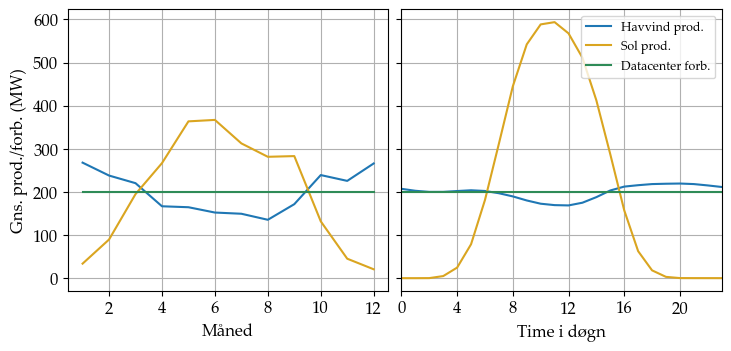

In [10]:
# 1. initiate
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3.4), constrained_layout=True, sharey=True)
# fig.suptitle(r' Figur 1: Gns. produktion/forbrug over $[2023-2025]$', y=-0.04)

# 2. month
ax[0].plot(df_m.month, df_m.offshore, label='Havvind prod.', color='tab:blue')
ax[0].plot(df_m.month, df_m.solar, label='Sol prod.', color='goldenrod')
ax[0].plot(df_m.month, df_m.datacenter, label='Datacenter forb.', color='seagreen')
ax[0].grid()
ax[0].set_xlabel("Måned", fontsize=12)
ax[0].set_ylabel(r"Gns. prod./forb. (MW)", fontsize=12)
ax[0].set_xticks(range(1, 13))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. day
ax[1].plot(df_h.hour, df_h.offshore, label='Havvind prod.', color='tab:blue')
ax[1].plot(df_h.hour, df_h.solar, label='Sol prod.', color='goldenrod')
ax[1].plot(df_h.hour, df_h.datacenter, label='Datacenter forb.', color='seagreen')
ax[1].grid()
ax[1].set_xlabel("Time i døgn", fontsize=12)
ax[1].legend(fontsize=9, loc='upper right')
ax[1].set_xticks(range(0, 24, 4))
ax[1].set_xlim(0, 23)

In [ ]:
# fig.savefig("Gns_produktion_forbrug_[2023-2025].png", dpi=300, bbox_inches="tight")   

*Sanity*

In [12]:
# 1. finding yearly agg
datacenter_agg = df.datacenter.sum() / 1e6
solar_fac_agg = df.solar_fac.sum() / 1e6
offshore_fac_agg = df.offshore_fac.sum() / 1e6

# 2. printing
print("Aggregated yearly production in TWh is then:")
print(f"{'For datacenters:':<18}{datacenter_agg:>8.2f} TWh")
print(f"{'For solar:':<18}{solar_fac_agg:>8.2f} TWh")
print(f"{'For Offshore wind:':<18}{offshore_fac_agg:>8.2f} TWh")
print(f'\nCorrect as 200 MW * 8760 h = {200*8760/1e6:.2f} TWh')

Aggregated yearly production in TWh is then:
For datacenters:      1.75 TWh
For solar:            1.75 TWh
For Offshore wind:    1.75 TWh

Correct as 200 MW * 8760 h = 1.75 TWh


#### 2.3 Degree of self sufficiency

*First performed per year*

In [13]:
# 1. make combination
df['VE_fac_sum'] = df.solar_fac + df.offshore_fac

# 2. bool for sufficient
df['sun_suff'] = df.solar_fac > df.datacenter
df['offshore_suff'] = df.offshore_fac > df.datacenter
df['VE_suff'] = df.VE_fac_sum > df.datacenter

# 3. share of sufficient hours
sun_suff_degree = df.sun_suff.sum() / 8760 
offshore_suff_degree = df.offshore_suff.sum() / 8760
VE_stuff_degree = df.VE_suff.sum() / 8760

# 3. printing
print("Repræsentativt årlig selvforsyningsgrad pr. Pt:")
print(f"{'Sol:':<14}{sun_suff_degree:>8.3f}")
print(f"{'Havvind:':<14}{offshore_suff_degree:>8.3f}")
print(f"{'Samlet:':<14}{VE_stuff_degree:>8.3f}")

Repræsentativt årlig selvforsyningsgrad pr. Pt:
Sol:             0.308
Havvind:         0.473
Samlet:          0.749


*Over the representative day*

In [14]:
# 1. make combination
df_h['VE_fac_sum'] = df_h.solar + df_h.offshore

# 2. bool for sufficient
df_h['sun_suff'] = df_h.solar > df_h.datacenter
df_h['offshore_suff'] = df_h.offshore > df_h.datacenter
df_h['VE_suff'] = df_h.VE_fac_sum > df_h.datacenter

# 3. share of sufficient hours
sun_suff_degree_d = df_h.sun_suff.sum() / 24 
offshore_suff_degree_d = df_h.offshore_suff.sum() / 24
VE_stuff_degree_d = df_h.VE_suff.sum() / 24

# 3. print (repræsentativt døgn)
print("Repræsentativt døgn selvforsyningsgrad pr. Pt:")
print(f"{'Sol:':<14}{sun_suff_degree_d:>8.3f}")
print(f"{'Havvind:':<14}{offshore_suff_degree_d:>8.3f}")
print(f"{'Samlet:':<14}{VE_stuff_degree_d:>8.3f}")

Repræsentativt døgn selvforsyningsgrad pr. Pt:
Sol:             0.375
Havvind:         0.667
Samlet:          1.000


### 3. Corresponding capacity

In [15]:
# 1. sun
indx_m['dfl_cap'] = 100 * indx_m.SolarPowerCapacity / indx_m.solar_cap_index
print(f'The deflated sun capacity at the last observation is {indx_m.iloc[-1].dfl_cap/1e3:.1f} GW')

The deflated sun capacity at the last observation is 3.2 GW


In [16]:
# 2. wind
# 2.1. call api
base = 'https://api.energidataservice.dk/dataset/CapacityPerMunicipality'

params = {
    "start": start,
    "end": end,
    "columns": "Month,OffshoreWindCapacity",
    "sort": "Month asc",
    "limit": 0,
}

r = requests.get(base, params=params, timeout=60)
r.raise_for_status()
df_ind = pd.DataFrame(r.json().get("records", []))

# 2. set up months
dt = pd.to_datetime(df_ind["Month"], errors="coerce")
df_ind["date"] = (
    dt.dt.to_period("M")
      .dt.to_timestamp(how="start")   # month start timestamps
)

# 2.2. aggregate
df_ws_m = df_ind.groupby('Month').OffshoreWindCapacity.sum().to_frame()

# 2.3 get last
print(f'The wind capacity is {df_ws_m.iloc[-1].OffshoreWindCapacity/1e3:.1f} GW')

The wind capacity is 2.6 GW


*Find needed capacities to satisfy datacenters' demand*

In [17]:
# 1. conpute
sun_cap = indx_m.iloc[-1].dfl_cap * fac_solar
offshore_cap = df_ws_m.iloc[-1].OffshoreWindCapacity * fac_offshore

# 2. print
print(f"Kapacitet (Sidste observation: {indx_m.iloc[-1].date:%Y-%m})")
print(f"{'Sol (deflateret):':<22}{indx_m.iloc[-1].dfl_cap:>8.1f} MW")
print(f"{'Havvind:':<22}{df_ws_m.iloc[-1].OffshoreWindCapacity:>8.1f} MW")
print("")
print("Nødvendig kapacitet for at dække datacenter-forbrug")
print(f"{'Sol:':<22}{sun_cap:>8.1f} MW  (faktor {fac_solar:>.3f})")
print(f"{'Havvind:':<22}{offshore_cap:>8.1f} MW  (faktor {fac_offshore:>.3f})")

Kapacitet (Sidste observation: 2025-12)
Sol (deflateret):       3160.0 MW
Havvind:                2643.5 MW

Nødvendig kapacitet for at dække datacenter-forbrug
Sol:                    2121.1 MW  (faktor 0.671)
Havvind:                 504.5 MW  (faktor 0.191)


*Implicit capacity factor*

In [18]:
# 1. compute
cap_fac_sun = df.solar_fac.sum() / (sun_cap *8760) 
cap_fac_offshore = df.offshore_fac.sum() / (offshore_cap *8760) 

# 2. print
print("Kapacitetsfaktor (impl.)")
print(f"{'Sol:':<10}{cap_fac_sun:>7.3f}")
print(f"{'Havvind:':<10}{cap_fac_offshore:>7.3f}")

Kapacitetsfaktor (impl.)
Sol:        0.094
Havvind:    0.396
